In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
from wonderwords import RandomWord
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random

In [23]:
# loop completion test

#model_path = "spatial_model/"
model_path = "new_model/"  # Path to the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grid_size = 3
num_trials = 1000

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
model.eval()

r = RandomWord()

delta_map = {"UP": (-1, 0), "DOWN": (1, 0), "LEFT": (0, -1), "RIGHT": (0, 1)}
dir_to_short = {"UP": "U", "DOWN": "D", "LEFT": "L", "RIGHT": "R"}
# dir_to_short = {"UP": "NORTH", "DOWN": "SOUTH", "LEFT": "WEST", "RIGHT": "EAST"}

def move(coord, direction):
    dx, dy = delta_map[direction]
    return (coord[0] + dx, coord[1] + dy)

def valid_coord(c):
    return 0 <= c[0] < grid_size and 0 <= c[1] < grid_size

def get_direction(prev, curr):
    dx = curr[0] - prev[0]
    dy = curr[1] - prev[1]
    for name, (ddx, ddy) in delta_map.items():
        if (dx, dy) == (ddx, ddy):
            return name
    return None

def generate_unique_nouns(n=9):
    nouns = set()
    while len(nouns) < n:
        word = r.word(include_parts_of_speech=["nouns"])
        if word:
            nouns.add(word.replace(" ", "_").lower())
    return list(nouns)

def generate_grid(size=3):
    nouns = generate_unique_nouns(size * size)
    grid = [nouns[i*size:(i+1)*size] for i in range(size)]
    coord_map = {grid[i][j]: (i, j) for i in range(size) for j in range(size)}
    inv_coord = {v: k for k, v in coord_map.items()}
    return grid, coord_map, inv_coord

def generate_loop_path():
    for _ in range(50):
        start = (random.randint(0, grid_size - 2), random.randint(0, grid_size - 2))
        path = [
            start,
            move(start, "RIGHT"),
            move(move(start, "RIGHT"), "DOWN"),
            move(move(move(start, "RIGHT"), "DOWN"), "LEFT")
        ]
        if all(valid_coord(p) for p in path):
            path.append(start)  # close loop
            return path
    return None

def build_prompt_without_final_noun(path, inv_coord):
    #prompt = f"MODE: Shortest, START: {inv_coord[path[0]]}, END: {inv_coord[path[0]]}, PATH: {inv_coord[path[0]]}"
    prompt = f"{inv_coord[path[0]]}"
    for i in range(1, len(path) - 1):
        prev, curr = path[i-1], path[i]
        direction = get_direction(prev, curr)
        noun = inv_coord[curr]
        prompt += f" {dir_to_short[direction]} {noun}"
    final_dir = get_direction(path[-2], path[-1])
    prompt += f" {dir_to_short[final_dir]}"
    return prompt, inv_coord[path[-1]]

def evaluate_final_noun(prompt, expected_noun):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=3,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    generated = tokenizer.decode(output[0][input_ids.shape[-1]:], skip_special_tokens=True).strip()
    predicted = generated.split()[0] if generated.split() else ""
    return predicted == expected_noun, predicted

# eval
correct = 0
wrong_preds = []

for _ in range(num_trials):
    grid, coord_map, inv_coord = generate_grid(grid_size)
    path = generate_loop_path()
    if not path:
        continue
    prompt, expected_noun = build_prompt_without_final_noun(path, inv_coord)
    is_correct, prediction = evaluate_final_noun(prompt, expected_noun)
    correct += int(is_correct)
    if not is_correct:
        wrong_preds.append((prompt, expected_noun, prediction))

# results
print("\nResults")
print(f"Total examples: {num_trials}")
print(f"Noun prediction accuracy: {correct / num_trials:.2%}")

if wrong_preds:
    print(f"\nIncorrect predictions ({len(wrong_preds)}):")
    for prompt, expected, pred in wrong_preds[:5]:
        print(f"\nPrompt: {prompt}\nExpected: {expected}\nPredicted: {pred}")


Results
Total examples: 1000
Noun prediction accuracy: 0.00%

Incorrect predictions (1000):

Prompt: fisherman R orchard D grandparent L cement U
Expected: fisherman
Predicted: id

Prompt: pub R pencil D wrapper L programme U
Expected: pub
Predicted: yu

Prompt: gaffe R sportsman D jug L fitness U
Expected: gaffe
Predicted: jg

Prompt: laugh R hamburger D stamina L exasperation U
Expected: laugh
Predicted: zu

Prompt: dibble R spouse D bitten L deformation U
Expected: dibble
Predicted: id


In [4]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

print("hazel:", tokenizer.tokenize("hazel"))
print("hazelnut:", tokenizer.tokenize("hazelnut"))


hazel: ['h', 'azel']
hazelnut: ['h', 'azel', 'nut']


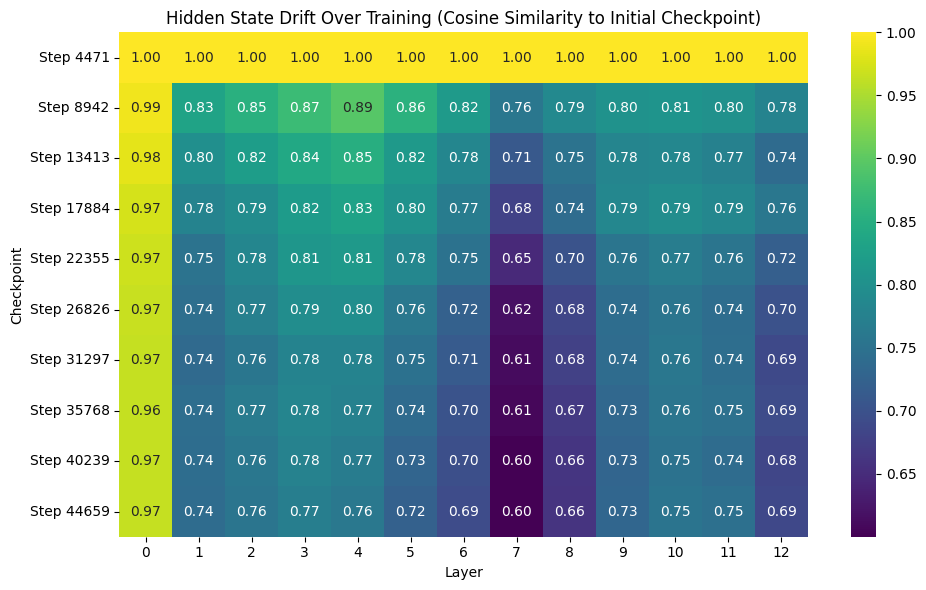

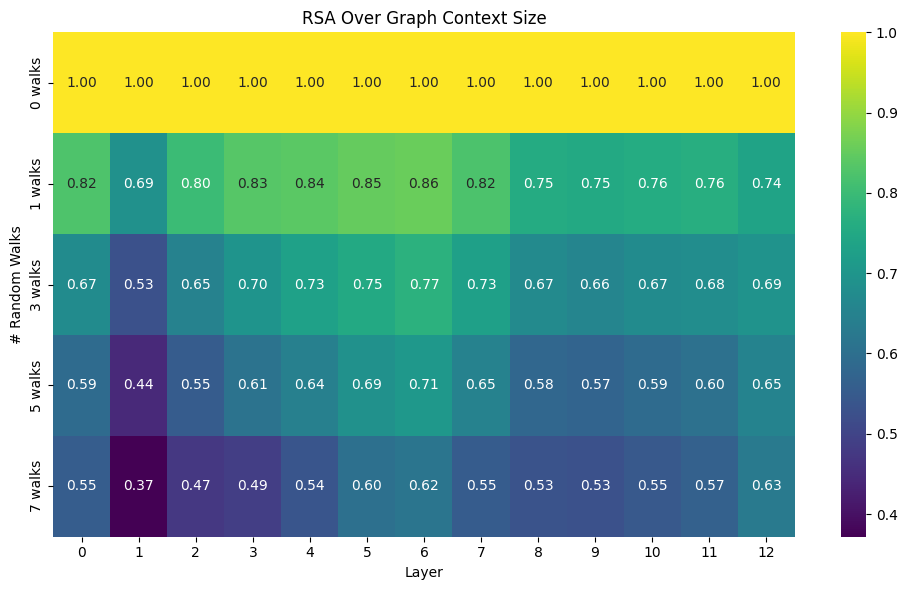

In [3]:
checkpoint_steps = [
    4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659
]

model_base_path = "spatial_model/checkpoint-{}"
device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(42)

# query
query_prompt = "MODE: Shortest, START: apple, END: orange, PATH:"

# nodes and directions
nodes = ["apple", "banana", "cat", "dog", "elephant", "fig", "grape", "orange"]
directions = ["UP", "DOWN", "LEFT", "RIGHT"]


tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def generate_random_walk(length=3):
    walk = []
    curr_node = random.choice(nodes)
    for _ in range(length):
        direction = random.choice(directions)
        next_node = random.choice(nodes)
        walk.append(f"{curr_node} {direction} {next_node}")
        curr_node = next_node
    return walk


def get_layerwise_representation(model, prompt):
    tokens = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
        return [torch.mean(layer[0], dim=0).cpu().numpy() for layer in outputs.hidden_states]


def compute_layerwise_similarity(rep_array):
    num = rep_array.shape[0]
    layers = rep_array.shape[1]
    sim_matrix = np.zeros((num, layers))
    for i in range(num):
        for j in range(layers):
            sim = cosine_similarity([rep_array[0, j]], [rep_array[i, j]])[0, 0]
            sim_matrix[i, j] = sim
    return sim_matrix


def plot_heatmap(data, title, xlabel, ylabel, xticks, yticks):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, cmap="viridis", xticklabels=xticks, yticklabels=yticks, annot=True, fmt=".2f")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# training representation similarity

reps_over_training = []

for step in checkpoint_steps:
    model = GPT2LMHeadModel.from_pretrained(model_base_path.format(step)).to(device)
    model.eval()
    rep = get_layerwise_representation(model, query_prompt)
    reps_over_training.append(rep)
    del model
    torch.cuda.empty_cache()

reps_over_training = np.array(reps_over_training)
sim_training = compute_layerwise_similarity(reps_over_training)

plot_heatmap(sim_training,
             title="Hidden State Drift Over Training (Cosine Similarity to Initial Checkpoint)",
             xlabel="Layer", ylabel="Checkpoint",
             xticks=list(range(sim_training.shape[1])),
             yticks=[f"Step {step}" for step in checkpoint_steps])

# context representation similarity
final_step = checkpoint_steps[-1]
model = GPT2LMHeadModel.from_pretrained(model_base_path.format(final_step)).to(device)
model.eval()

num_walks_list = [0, 1, 3, 5, 7]
reps_over_context = []

for num_walks in num_walks_list:
    walks = []
    for _ in range(num_walks):
        walks += generate_random_walk(length=3)
    prompt = " ".join(walks) + " " + query_prompt
    rep = get_layerwise_representation(model, prompt)
    reps_over_context.append(rep)

reps_over_context = np.array(reps_over_context)
sim_context = compute_layerwise_similarity(reps_over_context)

plot_heatmap(sim_context,
             title="RSA Over Graph Context Size",
             xlabel="Layer", ylabel="# Random Walks",
             xticks=list(range(sim_context.shape[1])),
             yticks=[f"{n} walks" for n in num_walks_list])


Processing checkpoint 4471


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Processing checkpoint 8942
Processing checkpoint 13413
Processing checkpoint 17884
Processing checkpoint 22355
Processing checkpoint 26826
Processing checkpoint 31297
Processing checkpoint 35768
Processing checkpoint 40239
Processing checkpoint 44659


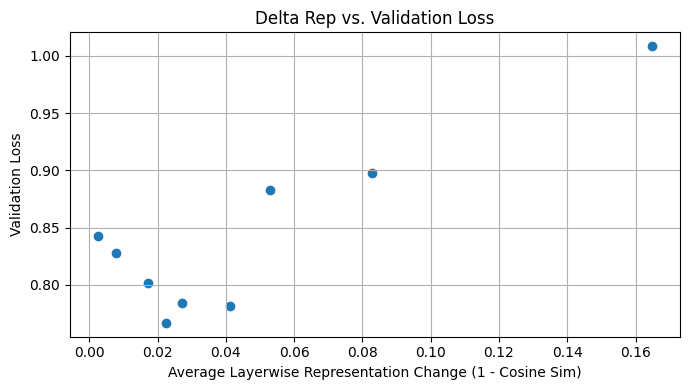

Spearman rho = 0.467, p = 0.2054


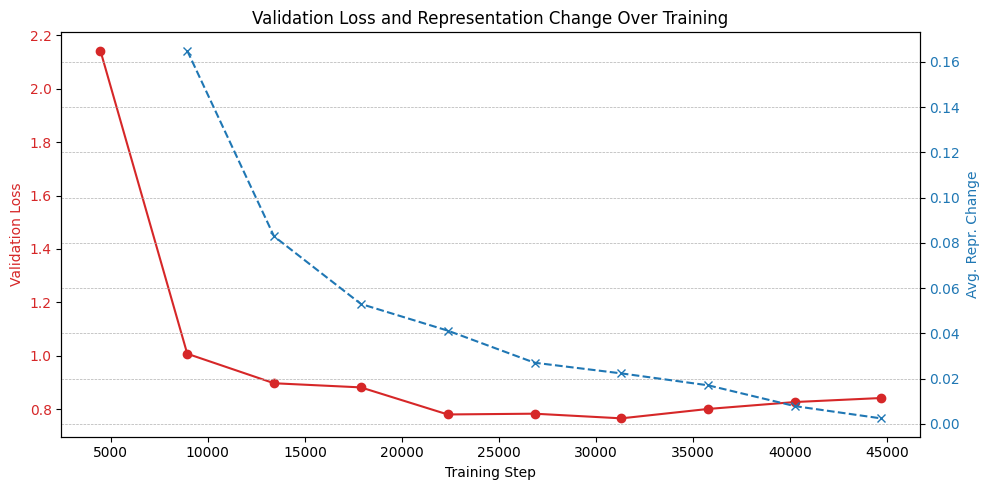

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr


checkpoint_steps = [4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659]
model_base_path = "spatial_model/checkpoint-{}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
query_prompt = "MODE: Shortest, START: apple, END: orange, PATH:"
test_path = "spatial_model/test.txt"


tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")


def get_layerwise_representation(model, prompt):
    tokens = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        return torch.stack([layer.mean(dim=1).squeeze(0) for layer in hidden_states]).cpu().numpy()  # [layers, hidden_dim]

def compute_val_loss(model, test_text):
    inputs = tokenizer(test_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        return outputs.loss.item()

def cosine_distance(a, b):
    return 1 - cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0]

with open(test_path, "r", encoding="utf-8") as f:
    test_text = f.read()

layerwise_reps = []  # [n_checkpoints, n_layers, hidden_dim]
val_losses = []


for step in checkpoint_steps:
    print(f"Processing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    # Collect hidden states and validation loss
    rep = get_layerwise_representation(model, query_prompt)
    loss = compute_val_loss(model, test_text)

    layerwise_reps.append(rep)
    val_losses.append(loss)

    del model
    torch.cuda.empty_cache()

# Convert to array
layerwise_reps = np.array(layerwise_reps)  # shape: [n_ckpts, n_layers, hidden_dim]
val_losses = np.array(val_losses)


delta_rep = []
for i in range(1, len(layerwise_reps)):
    diffs = [
        cosine_distance(layerwise_reps[i - 1][l], layerwise_reps[i][l])
        for l in range(layerwise_reps.shape[1])
    ]
    delta_rep.append(np.mean(diffs))

delta_rep = np.array(delta_rep)  # shape: [n_checkpoints - 1]
val_loss_shifted = val_losses[1:]  # align: delta_rep[i] → val_loss[i+1]

# delta_rep and validation loss scatter plot
plt.figure(figsize=(7, 4))
plt.scatter(delta_rep, val_loss_shifted)
plt.xlabel("Average Layerwise Representation Change (1 - Cosine Sim)")
plt.ylabel("Validation Loss")
plt.title("Delta Rep vs. Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


rho, pval = spearmanr(delta_rep, val_loss_shifted)
print(f"Spearman rho = {rho:.3f}, p = {pval:.4f}")

# delta rep and validation loss over training steps
fig, ax1 = plt.subplots(figsize=(10, 5))

# primary y-axis for validation loss
color = 'tab:red'
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(checkpoint_steps, val_losses, color=color, marker='o', linestyle='-', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)

# second y-axis for the representation change
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Avg. Repr. Change', color=color)
# Plot delta_rep against the END of the interval (e.g., change from step 1 to 2 is plotted at step 2)
ax2.plot(checkpoint_steps[1:], delta_rep, color=color, marker='x', linestyle='--', label='Delta Rep')
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Validation Loss and Representation Change Over Training')
fig.tight_layout()  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Processing checkpoint 4471
Step 4471 - Collected 433 tokens.
Role distribution: {'corner': 151, 'edge': 213, 'center': 69}

Processing checkpoint 8942
Step 8942 - Collected 452 tokens.
Role distribution: {'edge': 220, 'corner': 159, 'center': 73}

Processing checkpoint 13413
Step 13413 - Collected 452 tokens.
Role distribution: {'edge': 212, 'corner': 173, 'center': 67}

Processing checkpoint 17884
Step 17884 - Collected 446 tokens.
Role distribution: {'edge': 219, 'corner': 163, 'center': 64}

Processing checkpoint 22355
Step 22355 - Collected 444 tokens.
Role distribution: {'edge': 213, 'corner': 172, 'center': 59}

Processing checkpoint 26826
Step 26826 - Collected 459 tokens.
Role distribution: {'corner': 177, 'edge': 220, 'center': 62}

Processing checkpoint 31297
Step 31297 - Collected 447 tokens.
Role distribution: {'corner': 170, 'edge': 220, 'center': 57}

Processing checkpoint 35768
Step 35768 - Collected 439 tokens.
Role distribution: {'corner': 163, 'edge': 210, 'center': 

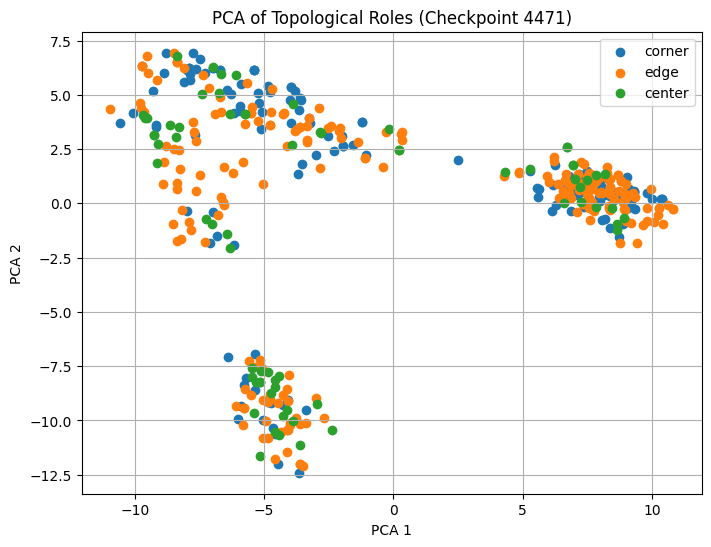

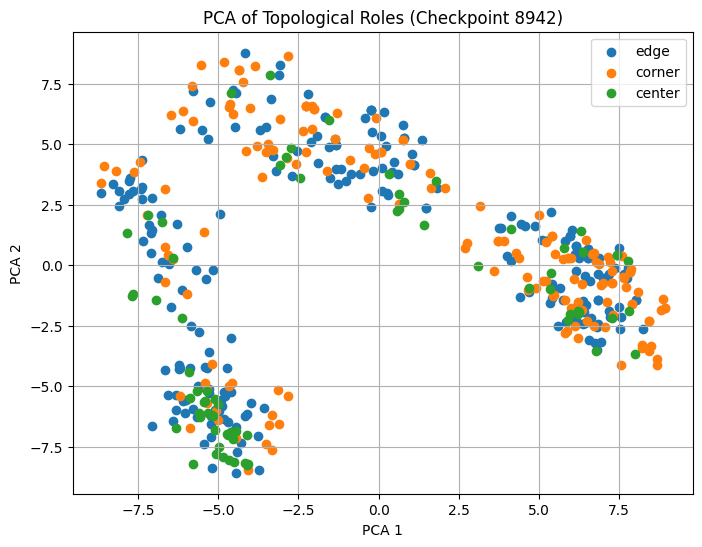

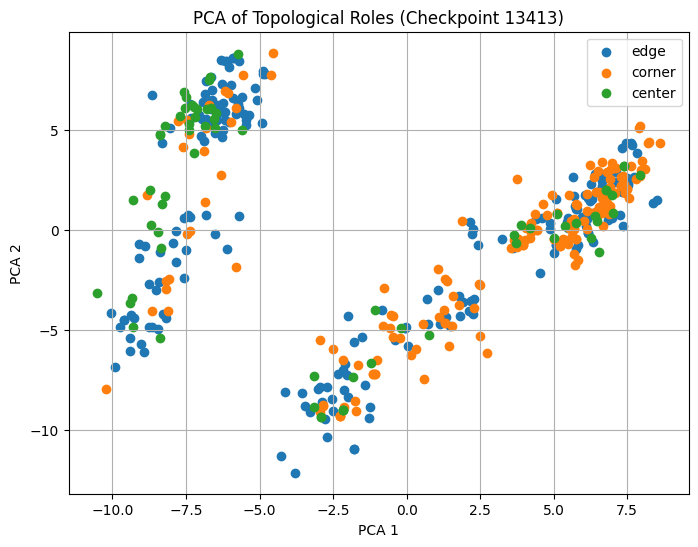

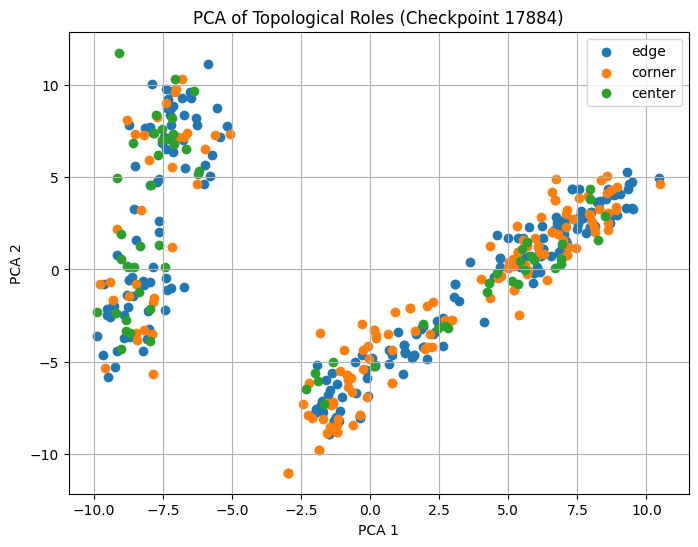

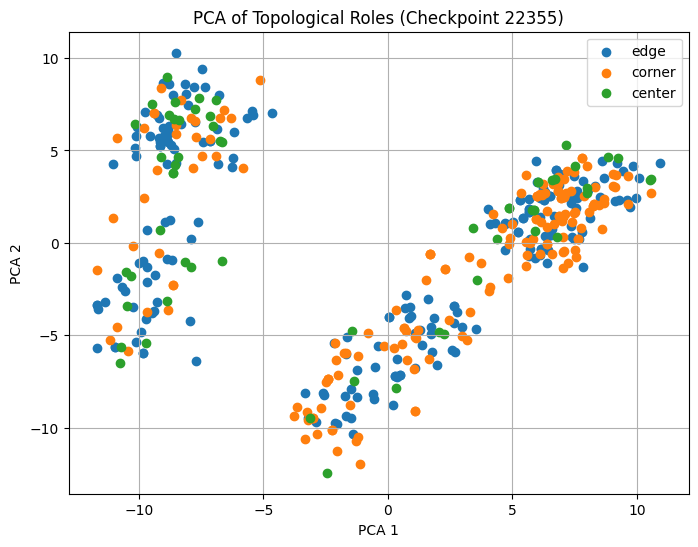

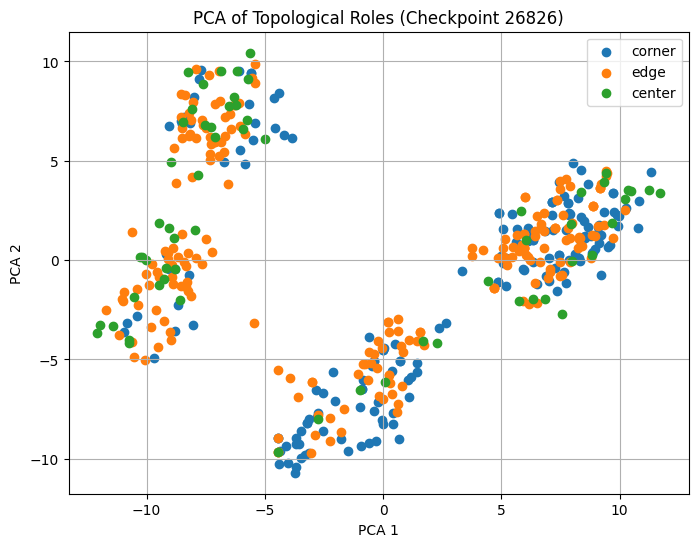

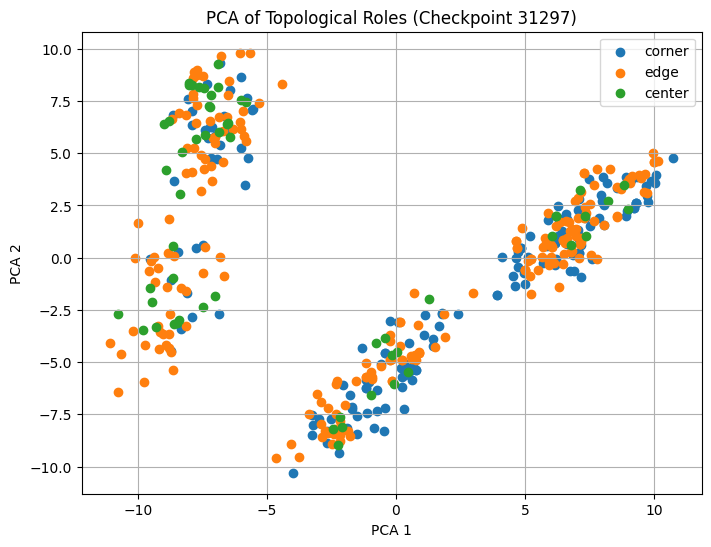

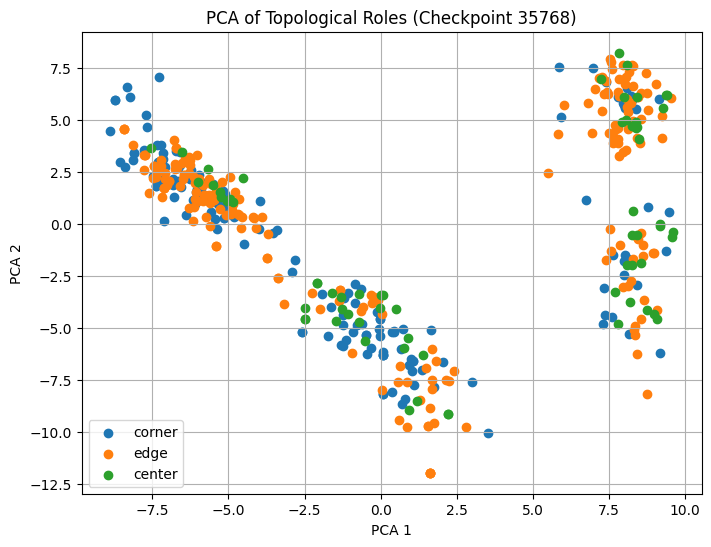

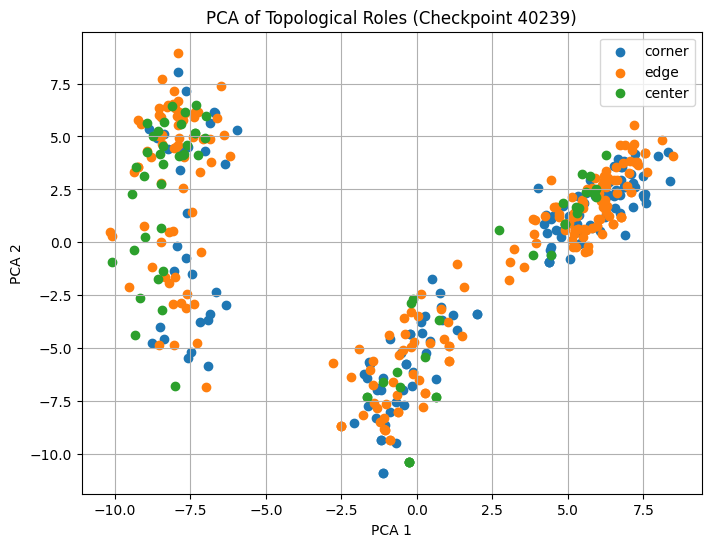

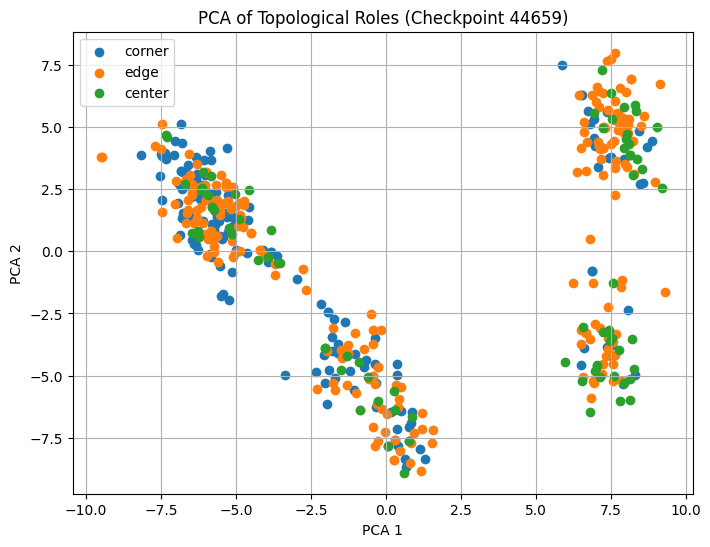


Silhouette Scores by Checkpoint:
Step 4471: -0.008
Step 8942: -0.002
Step 13413: 0.000
Step 17884: -0.004
Step 22355: -0.005
Step 26826: -0.003
Step 31297: -0.005
Step 35768: -0.002
Step 40239: -0.003
Step 44659: -0.002


In [5]:
import os
import random
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wonderwords import RandomWord
import matplotlib.patches as patches

device = "cuda" if torch.cuda.is_available() else "cpu"
grid_size = 3
prompts_per_grid = 5
checkpoints = [
    4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659
]

model_base_path = "spatial_model/checkpoint-{}"
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
Random_Word = RandomWord()


def generate_nouns(size):
    nouns = set()
    while len(nouns) < size * size:
        word = Random_Word.word(include_parts_of_speech=["nouns"]).replace(" ", "_")
        nouns.add(word)
    return list(nouns)

def create_unique_random_grid(nouns, size):
    selected = random.sample(nouns, size * size)
    return [selected[i * size:(i + 1) * size] for i in range(size)]

def get_topological_role(coord, size):
    x, y = coord
    if (x == 0 or x == size - 1) and (y == 0 or y == size - 1):
        return "corner"
    elif x == 0 or y == 0 or x == size - 1 or y == size - 1:
        return "edge"
    else:
        return "center"

def get_direction(prev, curr):
    if curr[0] == prev[0]:
        return "R" if curr[1] > prev[1] else "L"
    else:
        return "D" if curr[0] > prev[0] else "U"

def get_neighbors(coord, size):
    x, y = coord
    dirs = {"U": (x - 1, y), "D": (x + 1, y), "L": (x, y - 1), "R": (x, y + 1)}
    result = []
    for d, (nx, ny) in dirs.items():
        if 0 <= nx < size and 0 <= ny < size:
            result.append(d)
        else:
            result.append("NA")
    return f"[{' '.join(result)}]"

def generate_random_path(size):
    coords = [(i, j) for i in range(size) for j in range(size)]
    start, end = random.sample(coords, 2)
    queue = [[start]]
    while queue:
        path = queue.pop(0)
        if path[-1] == end:
            return path
        x, y = path[-1]
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < size and 0 <= ny < size and (nx, ny) not in path):
                queue.append(path + [(nx, ny)])
    return []

def generate_prompt(grid, path):
    prompt = f"MODE: Shortest, START: {grid[path[0][0]][path[0][1]]}, END: {grid[path[-1][0]][path[-1][1]]}, PATH: "
    token_coords = {}
    start_token = grid[path[0][0]][path[0][1]].lower().strip()
    prompt += start_token
    token_coords[start_token] = path[0]
    prev = path[0]
    for i in range(1, len(path)):
        curr = path[i]
        dir = get_direction(prev, curr)
        if i == 1:
            prompt += f" {get_neighbors(prev, grid_size)} {dir}"
        else:
            prompt += f" {dir}"
        word = grid[curr[0]][curr[1]].lower().strip()
        prompt += f" {word}"
        token_coords[word] = curr
        prev = curr
    return prompt, token_coords

def visualize_grid_with_roles(grid, path_coords, prompt):
    fig, ax = plt.subplots(figsize=(5, 5))
    role_colors = {"corner": "green", "edge": "blue", "center": "orange"}

    for i in range(grid_size):
        for j in range(grid_size):
            coord = (i, j)
            word = grid[i][j]
            role = get_topological_role(coord, grid_size)
            color = role_colors[role]

            rect = patches.Rectangle((j, grid_size - 1 - i), 1, 1, linewidth=1, edgecolor='black', facecolor=color, alpha=0.3)
            ax.add_patch(rect)
            ax.text(j + 0.5, grid_size - 1 - i + 0.5, word, ha='center', va='center', fontsize=9)

    for i in range(len(path_coords) - 1):
        x1, y1 = path_coords[i][1], grid_size - 1 - path_coords[i][0]
        x2, y2 = path_coords[i+1][1], grid_size - 1 - path_coords[i+1][0]
        ax.arrow(x1 + 0.5, y1 + 0.5, x2 - x1, y2 - y1, head_width=0.15, head_length=0.15, fc='red', ec='red', length_includes_head=True)

    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Grid with Roles and Path")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    print("\nGenerated Prompt:\n" + prompt + "\n")

def extract_hidden_state(prompt, token, model):
    token = token.lower().strip()
    token_start = prompt.lower().find(token)
    if token_start == -1:
        return None

    inputs = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    offset_mapping = inputs["offset_mapping"][0]

    token_index = None
    for i, (start, end) in enumerate(offset_mapping):
        if start <= token_start < end or (start == token_start and end - start == len(token)):
            token_index = i
            break

    if token_index is None:
        return None

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states
        reps = torch.stack([layer[0, token_index] for layer in hidden_states[1:]])
        return reps.mean(dim=0).cpu().numpy()

# main loop to process checkpoints
silhouette_scores = {}
pca_embeddings = {}

for step in checkpoints:
    print(f"\nProcessing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    reps = []
    roles = []
    plotted = False

    for _ in range(30):
        nouns = generate_nouns(grid_size)
        grid = create_unique_random_grid(nouns, grid_size)

        for _ in range(prompts_per_grid):
            path = generate_random_path(grid_size)
            if not path: continue

            prompt, token_coords = generate_prompt(grid, path)

            # if not plotted:
            #     print(f"Checkpoint {step} - Example grid and path:")
            #     visualize_grid_with_roles(grid, path, prompt)
            #     plotted = True

            for token, coord in token_coords.items():
                role = get_topological_role(coord, grid_size)
                rep = extract_hidden_state(prompt, token, model)
                if rep is not None:
                    reps.append(rep)
                    roles.append(role)

    print(f"Step {step} - Collected {len(roles)} tokens.")
    print(f"Role distribution: {dict((r, roles.count(r)) for r in set(roles))}")

    if len(set(roles)) >= 2:
        X = np.array(reps)
        y = np.array([["corner", "edge", "center"].index(r) for r in roles])
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        pca_embeddings[step] = (X_reduced, roles)
        silhouette_scores[step] = silhouette_score(X, y)

    del model
    torch.cuda.empty_cache()

# plot pca
for step, (X_reduced, labels) in pca_embeddings.items():
    plt.figure(figsize=(8, 6))
    for role in set(labels):
        idxs = [i for i, r in enumerate(labels) if r == role]
        plt.scatter(X_reduced[idxs, 0], X_reduced[idxs, 1], label=role)
    plt.title(f"PCA of Topological Roles (Checkpoint {step})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# silhouette scores
print("\nSilhouette Scores by Checkpoint:")
for step, score in silhouette_scores.items():
    print(f"Step {step}: {score:.3f}")


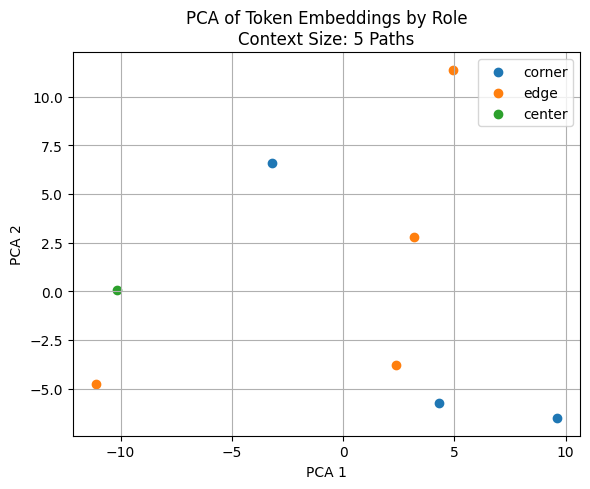

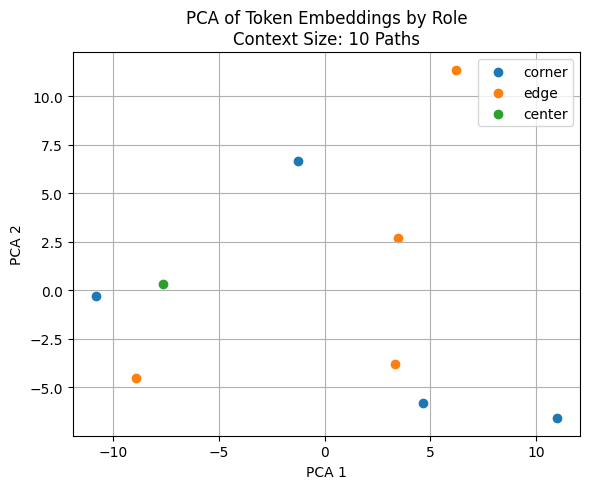

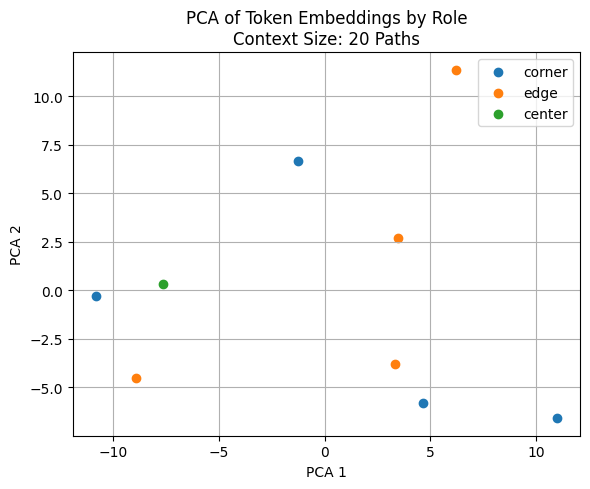

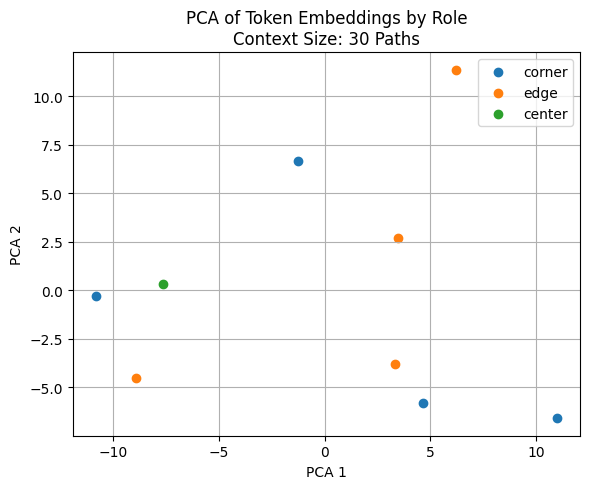

In [6]:
# Context size experiment
## generate one grid, simulate paths along that grid, concatenate an increasing no of paths into one prompt

from collections import defaultdict


model_path = model_base_path.format(44659)
context_sizes = [5, 10, 20, 30]


model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
model.eval()


nouns = generate_nouns(grid_size)
grid = create_unique_random_grid(nouns, grid_size)

# Generate a pool of paths
all_paths = []
while len(all_paths) < max(context_sizes):
    path = generate_random_path(grid_size)
    if path:
        all_paths.append(path)

# Track noun → coord
noun_coord_map = {}
for i in range(grid_size):
    for j in range(grid_size):
        token = grid[i][j].lower().strip()
        noun_coord_map[token] = (i, j)

# experiment
for size in context_sizes:
    paths = all_paths[:size]
    full_prompt = ""
    for path in paths:
        prompt_part, _ = generate_prompt(grid, path)
        full_prompt += prompt_part + " "

    # For each noun in the grid, extract rep if present
    reps = []
    roles = []
    for token, coord in noun_coord_map.items():
        role = get_topological_role(coord, grid_size)
        rep = extract_hidden_state(full_prompt, token, model)
        if rep is not None:
            reps.append(rep)
            roles.append(role)

    if len(set(roles)) < 2:
        print(f"Context size {size}: not enough role diversity for PCA.")
        continue

    # PCA
    X = np.array(reps)
    y = np.array(roles)
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(6, 5))
    for role in set(roles):
        idxs = [i for i, r in enumerate(roles) if r == role]
        plt.scatter(X_reduced[idxs, 0], X_reduced[idxs, 1], label=role)
    plt.title(f"PCA of Token Embeddings by Role\nContext Size: {size} Paths")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from wonderwords import RandomWord

# RSA between hidden reps and coordinates over time (checkpoints)
context_variant = "medium_path"
path_length = 5
repeats = 100
grid_size = 3
checkpoints = [4471, 8942, 13413, 17884, 22355, 26826, 31297, 35768, 40239, 44659]
model_base_path = "spatial_model/checkpoint-{}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
Random_Word = RandomWord()


def generate_nouns(size):
    nouns = set()
    while len(nouns) < size * size:
        word = Random_Word.word(include_parts_of_speech=["nouns"]).replace(" ", "_")
        nouns.add(word)
    return list(nouns)


def create_unique_random_grid(nouns, size):
    selected = random.sample(nouns, size * size)
    return [selected[i * size:(i + 1) * size] for i in range(size)]


def get_direction(prev, curr):
    if curr[0] == prev[0]:
        return "R" if curr[1] > prev[1] else "L"
    else:
        return "D" if curr[0] > prev[0] else "U"


def generate_random_path(size):
    coords = [(i, j) for i in range(size) for j in range(size)]
    start, end = random.sample(coords, 2)
    queue = [[start]]
    while queue:
        path = queue.pop(0)
        if path[-1] == end:
            return path
        x, y = path[-1]
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if (0 <= nx < size and 0 <= ny < size and (nx, ny) not in path):
                queue.append(path + [(nx, ny)])
    return []


def generate_prompt(grid, path):
    prompt = f"MODE: Shortest, START: {grid[path[0][0]][path[0][1]]}, END: {grid[path[-1][0]][path[-1][1]]}, PATH: "
    token_coords = {}
    start_token = grid[path[0][0]][path[0][1]].lower().strip()
    prompt += start_token
    token_coords[start_token] = path[0]
    prev = path[0]
    for i in range(1, len(path)):
        curr = path[i]
        dir = get_direction(prev, curr)
        prompt += f" {dir}"
        word = grid[curr[0]][curr[1]].lower().strip()
        prompt += f" {word}"
        token_coords[word] = curr
        prev = curr
    return prompt, token_coords


def extract_hidden_state(prompt, token, model):
    token = token.lower().strip()
    token_start = prompt.lower().find(token)
    if token_start == -1:
        return None
    inputs = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    offset_mapping = inputs["offset_mapping"][0]
    token_index = None
    for i, (start, end) in enumerate(offset_mapping):
        if start <= token_start < end or (start == token_start and end - start == len(token)):
            token_index = i
            break
    if token_index is None:
        return None
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states
        reps = torch.stack([layer[0, token_index] for layer in hidden_states[1:]])
        return reps.mean(dim=0).cpu().numpy()


def compute_rsa(hidden_states, coords):
    dist_model = squareform(pdist(hidden_states, metric='cosine'))
    dist_coords = squareform(pdist(coords, metric='cityblock'))  # Use Manhattan distance
    triu_idx = np.triu_indices(len(coords), k=1)
    rsa_score, _ = spearmanr(dist_model[triu_idx], dist_coords[triu_idx])
    return rsa_score


rsa_scores = {}
null_rsa_scores = {}

for step in checkpoints:
    print(f"\nProcessing checkpoint {step}")
    model_path = model_base_path.format(step)
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    model.eval()

    step_real_scores = []
    step_null_scores = []

    for _ in range(repeats):
        reps = []
        coords = []

        nouns = generate_nouns(grid_size)
        grid = create_unique_random_grid(nouns, grid_size)

        attempts = 0
        while True:
            path = generate_random_path(grid_size)
            if len(path) >= path_length:
                break
            attempts += 1
            if attempts > 100:
                break

        prompt, token_coords = generate_prompt(grid, path)
        token_sequence = list(token_coords.keys())

        for i, token in enumerate(token_sequence):
            rep = extract_hidden_state(prompt, token, model)
            if rep is not None:
                reps.append(rep)
                coords.append(path[i])

        if len(reps) != len(coords) or len(reps) < 3:
            continue

        reps = np.array(reps)
        coords = np.array(coords)

        # Real RSA
        real_rsa = compute_rsa(reps, coords)
        step_real_scores.append(real_rsa)

        # Null RSA: shuffle coords
        shuffled_coords = coords.copy()
        np.random.shuffle(shuffled_coords)
        null_rsa = compute_rsa(reps, shuffled_coords)
        step_null_scores.append(null_rsa)

    if step_real_scores:
        rsa_scores[step] = (np.mean(step_real_scores), np.std(step_real_scores))
        null_rsa_scores[step] = (np.mean(step_null_scores), np.std(step_null_scores))
        print(f"Checkpoint {step}: Real RSA = {rsa_scores[step][0]:.3f} ± {rsa_scores[step][1]:.3f}, "
              f"Null RSA = {null_rsa_scores[step][0]:.3f} ± {null_rsa_scores[step][1]:.3f}")

    del model
    torch.cuda.empty_cache()


# plotting
steps = list(rsa_scores.keys())
real_means = [rsa_scores[step][0] for step in steps]
real_stds = [rsa_scores[step][1] for step in steps]
null_means = [null_rsa_scores[step][0] for step in steps]
null_stds = [null_rsa_scores[step][1] for step in steps]

plt.figure(figsize=(10, 6))
plt.errorbar(steps, real_means, yerr=real_stds, fmt='-o', label='Real RSA', capsize=4)
plt.errorbar(steps, null_means, yerr=null_stds, fmt='--o', label='Shuffled RSA', capsize=4)
plt.title('RSA vs. Shuffled RSA Across Checkpoints')
plt.xlabel('Checkpoint')
plt.ylabel('RSA Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Processing checkpoint 4471
Checkpoint 4471: Real RSA = 0.044 ± 0.331, Null RSA = 0.003 ± 0.317

Processing checkpoint 8942
Checkpoint 8942: Real RSA = 0.076 ± 0.278, Null RSA = -0.027 ± 0.303

Processing checkpoint 13413
Checkpoint 13413: Real RSA = 0.056 ± 0.315, Null RSA = -0.032 ± 0.330

Processing checkpoint 17884
Checkpoint 17884: Real RSA = 0.062 ± 0.335, Null RSA = -0.088 ± 0.307

Processing checkpoint 22355
Checkpoint 22355: Real RSA = 0.079 ± 0.323, Null RSA = 0.039 ± 0.356

Processing checkpoint 26826
Checkpoint 26826: Real RSA = 0.084 ± 0.333, Null RSA = -0.005 ± 0.295

Processing checkpoint 31297
Checkpoint 31297: Real RSA = 0.033 ± 0.325, Null RSA = -0.010 ± 0.339

Processing checkpoint 35768
Checkpoint 35768: Real RSA = 0.076 ± 0.284, Null RSA = -0.094 ± 0.338

Processing checkpoint 40239
Checkpoint 40239: Real RSA = 0.037 ± 0.302, Null RSA = 0.020 ± 0.314

Processing checkpoint 44659
